## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images and distort un image

done


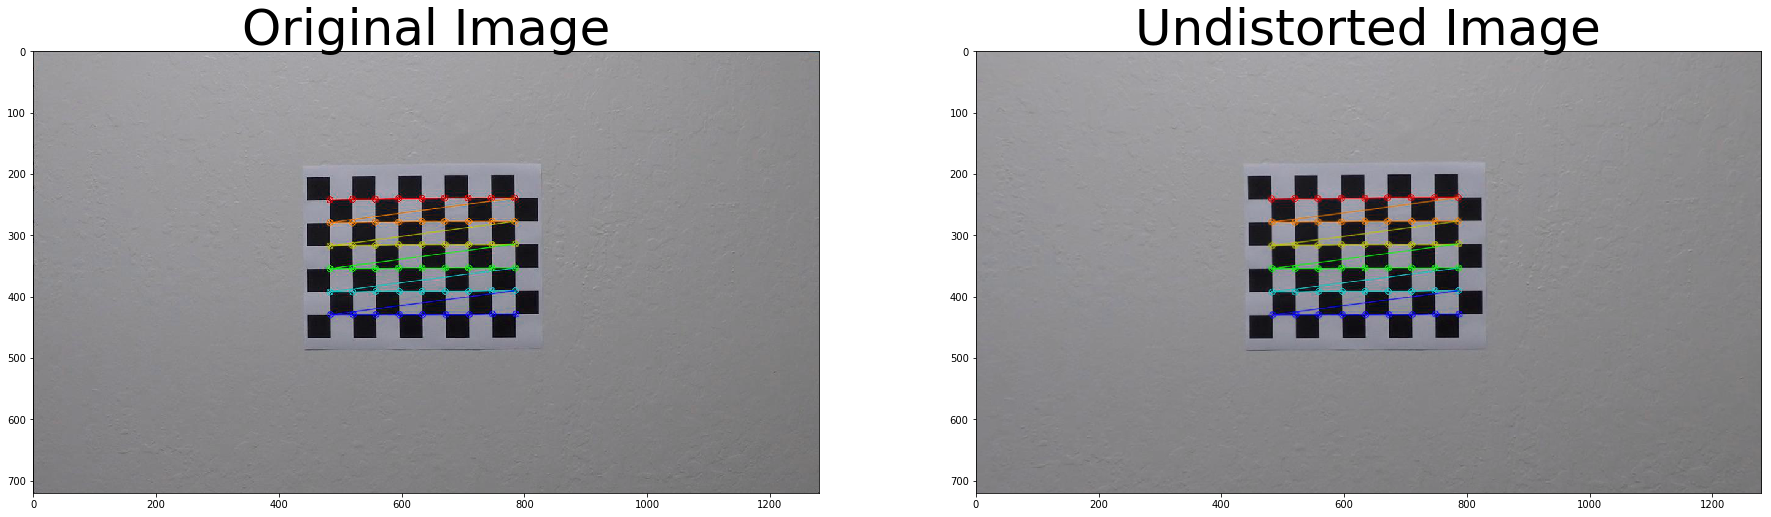

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal_projet/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        soln = scipy.misc.toimage(img)
        outfile = '../camera_cal_out'+os.path.splitext(fname)[0][20:] + "_drawpoints.jpg"
        soln.save(outfile, "JPEG")
        
#calibrate camera and distort un image
img = cv2.imread('/Users/zhanglingming/CarND-Advanced-Lane-Lines-master/camera_cal_out/calibration6_drawpoints.jpg')
def undistort(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[:-1], None, None)
    undist=cv2.undistort(image, mtx, dist, mtx)
    return undist,mtx,dist
undist,mtx,dist = undistort(img, objpoints, imgpoints)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print('done')

done


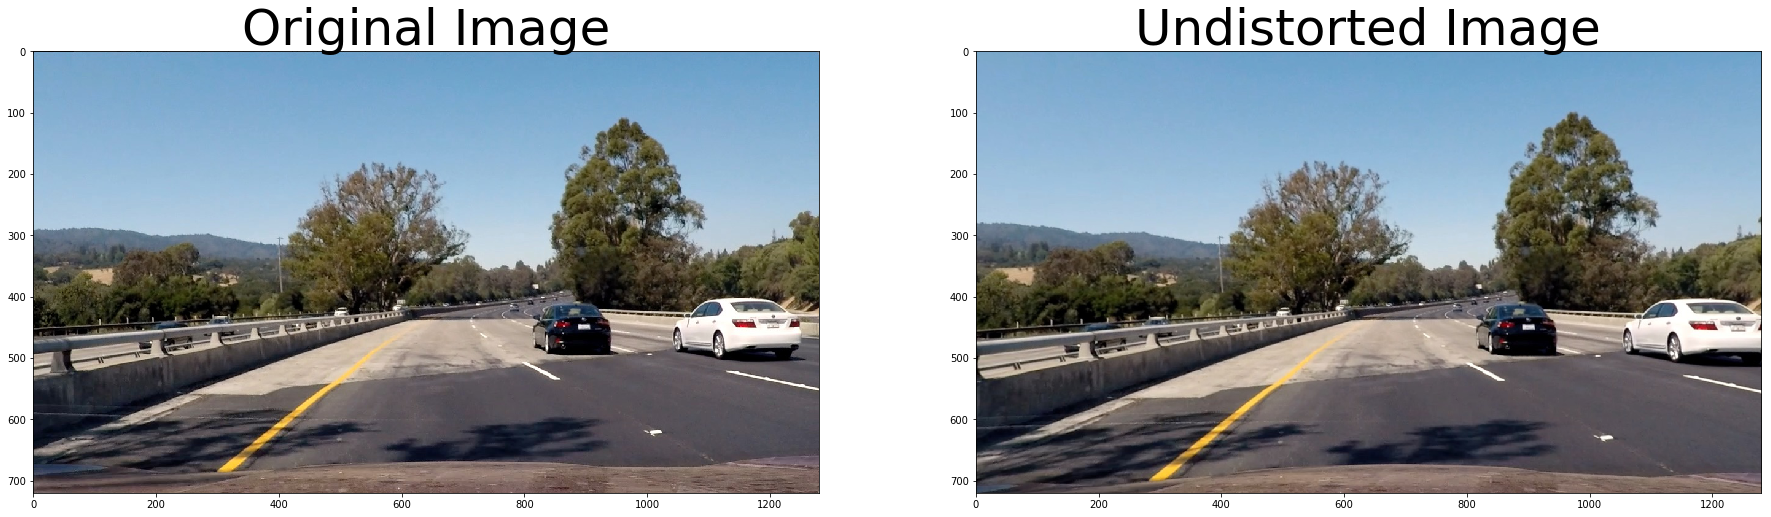

In [91]:
#distort function
import matplotlib.image as mpimg
img = mpimg.imread('/Users/zhanglingming/CarND-Advanced-Lane-Lines-master/test_images/test4.jpg')

def undistort_image(image,mtx,dist):
    undist=cv2.undistort(image, mtx, dist, mtx)
    return undist

undist = undistort_image(img, mtx, dist)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print('done')

## Thresholding

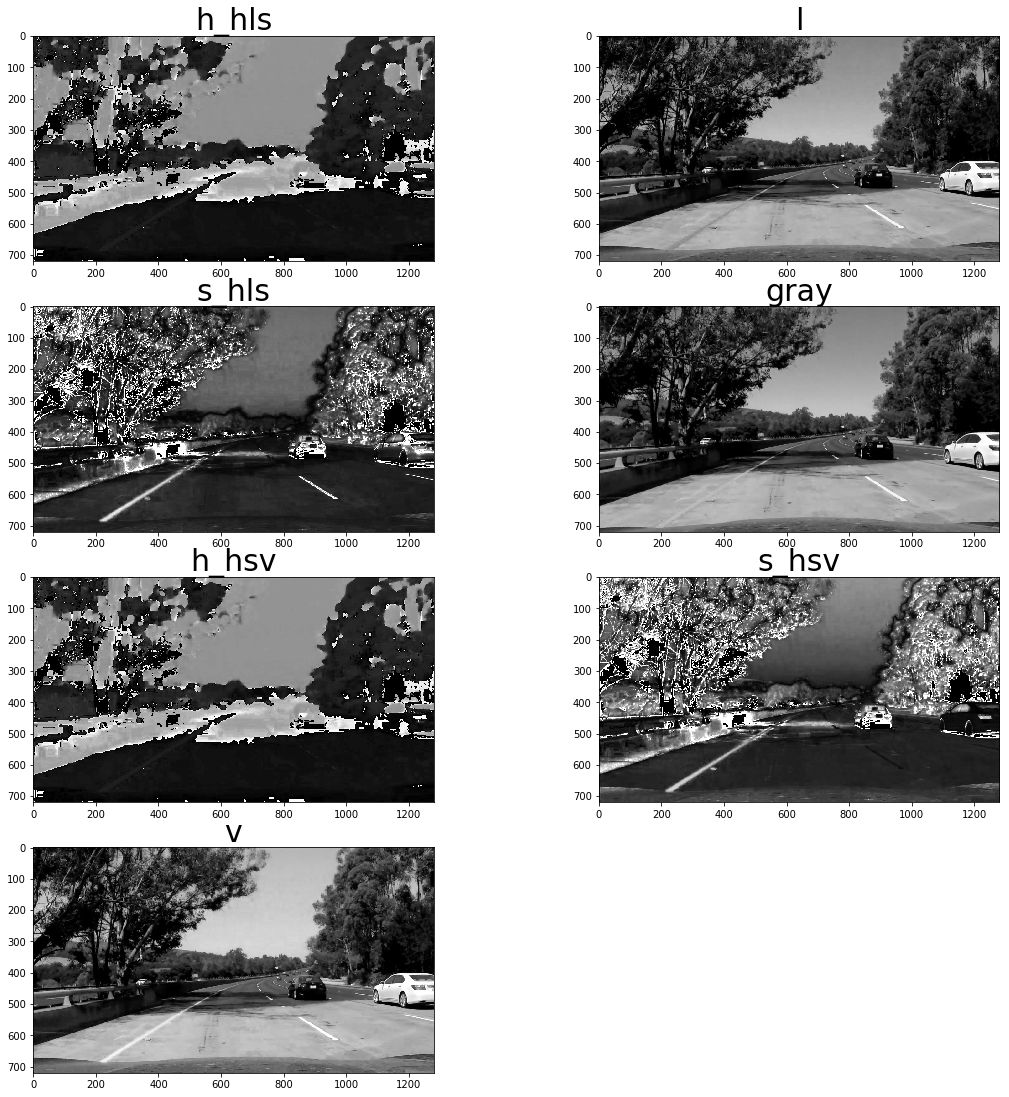

In [74]:
#test different color space
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)#gray.shape->(720,1280)
hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
h_hls = hls[:,:,0]
l = hls[:,:,1]
s_hls = hls[:,:,2]
hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV).astype(np.float)
h_hsv = hsv[:,:,0]
s_hsv = hsv[:,:,1]
v = hsv[:,:,2]
fig = plt.figure(figsize=(48, 18))
ax1 = fig.add_subplot(4,2,1)
ax1.imshow(h_hls,cmap='gray')
ax1.set_title('h_hls', fontsize=30)
ax2 = fig.add_subplot(4,2,2)
ax2.imshow(l, cmap='gray')
ax2.set_title('l', fontsize=30)
ax3 = fig.add_subplot(4,2,3)
ax3.imshow(s_hls,cmap='gray')
ax3.set_title('s_hls', fontsize=30)
ax4 = fig.add_subplot(4,2,4)
ax4.imshow(gray,cmap='gray')
ax4.set_title('gray', fontsize=30)
ax5 = fig.add_subplot(4,2,5)
ax5.imshow(h_hsv,cmap='gray')
ax5.set_title('h_hsv', fontsize=30)
ax6 = fig.add_subplot(4,2,6)
ax6.imshow(s_hsv, cmap='gray')
ax6.set_title('s_hsv', fontsize=30)
ax7 = fig.add_subplot(4,2,7)
ax7.imshow(v,cmap='gray')
ax7.set_title('v', fontsize=30)
plt.subplots_adjust(left=0., right=0.3, top=0.8, bottom=0.)

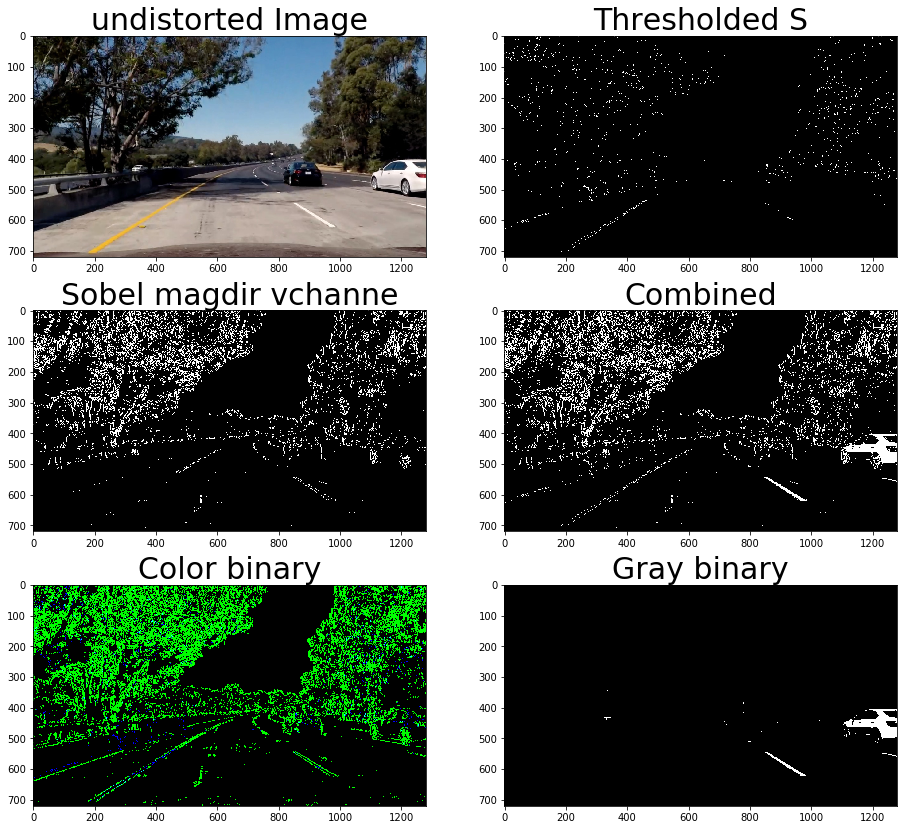

In [86]:
def hls_select(img, threshmag=(0, 255), threshdir=(0,1.0)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    h_hls = hls[:,:,0]
    l = hls[:,:,1]
    s_hls = hls[:,:,2]#s.shape->(720,1280)
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV).astype(np.float)
    h_hsv = hsv[:,:,0]
    s_hsv = hsv[:,:,1]
    v = hsv[:,:,2]
    
    sobelx = np.absolute(cv2.Sobel(s_hls,cv2.CV_64F,1,0))
    sobely = np.absolute(cv2.Sobel(s_hls,cv2.CV_64F,0,1))
    sobelmag = np.sqrt(sobelx**2+sobely**2)
    theta = np.arctan2(sobely,sobelx)
    
    s_binary = np.zeros_like(s)
    s_binary[(s_hls>=threshmag[0])&(s_hls<=threshmag[1])&(theta>=threshdir[0])&(theta<=threshdir[1])]=1
    return s_binary

hls_binary = hls_select(undist, threshmag=(170, 200),threshdir=(0,1.0))

def sobelx_select(img,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s_hls = hls[:,:,2]
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV).astype(np.float)
    h = hsv[:,:,0]
    s_hsv = hsv[:,:,1]
    v = hsv[:,:,2]
    sobelx = cv2.Sobel(v,cv2.CV_64F,1,0)
    scaled = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    sobelx_binary = np.zeros_like(scaled)
    sobelx_binary[(scaled>=thresh[0])&(scaled<=thresh[1])]=1
    return sobelx_binary

sobelx_binary = sobelx_select(undist,thresh=(10,100))

def sobelmagdir_select(img,threshmag=(0,255),threshdir=(0,np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS).astype(np.float)
    h_hls = hls[:,:,0]
    l = hls[:,:,1]
    s_hls = hls[:,:,2]
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV).astype(np.float)
    h_hsv = hsv[:,:,0]
    s_hsv = hsv[:,:,1]
    v = hsv[:,:,2]
    sobelx = np.absolute(cv2.Sobel(v,cv2.CV_64F,1,0))
    sobely = np.absolute(cv2.Sobel(v,cv2.CV_64F,0,1))
    sobelmag = np.sqrt(sobelx**2+sobely**2)
    theta = np.arctan2(sobely,sobelx)
    scaled = np.uint8(255*sobelmag/np.max(sobelmag))
    sobelmagdir_binary = np.zeros_like(scaled)
    sobelmagdir_binary[(scaled>=threshmag[0])&(scaled<=threshmag[1])&(theta>=threshdir[0])&(theta<=threshdir[1])]=1
    return sobelmagdir_binary

sobelmagdir_binary = sobelmagdir_select(undist,threshmag=(25,90),threshdir=(0,1.0))

def gray_thresh(img,thresh=(0,255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    gray_binary = np.zeros_like(gray)
    gray_binary[(gray>=thresh[0])&(gray<=thresh[1])]=1
    return gray_binary

gray_binary = gray_thresh(undist,thresh=(210,255))

combined_binary = np.zeros_like(sobelx_binary)
combined_binary[(hls_binary==1)|(sobelmagdir_binary==1)|(gray_binary==1)]=1

color_binary = np.dstack((np.zeros_like(sobelx_binary),sobelx_binary,hls_binary))

fig = plt.figure(figsize=(24, 9))
ax1 = fig.add_subplot(3,2,1)
ax1.imshow(undist)
ax1.set_title('undistorted Image', fontsize=30)
ax2 = fig.add_subplot(3,2,2)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=30)
ax3 = fig.add_subplot(3,2,3)
ax3.imshow(sobelmagdir_binary,cmap='gray')
ax3.set_title('Sobel magdir vchanne', fontsize=30)
ax4 = fig.add_subplot(3,2,4)
ax4.imshow(combined_binary,cmap='gray')
ax4.set_title('Combined', fontsize=30)
ax5 = fig.add_subplot(3,2,5)
ax5.imshow(color_binary)
ax5.set_title('Color binary', fontsize=30)
ax6 = fig.add_subplot(3,2,6)
ax6.imshow(gray_binary,cmap='gray')
ax6.set_title('Gray binary', fontsize=30)
plt.subplots_adjust(left=0., right=0.5, top=1.2, bottom=0.)

## Perspective transform

(720, 1280)


Text(0.5,1,'Warped Image')

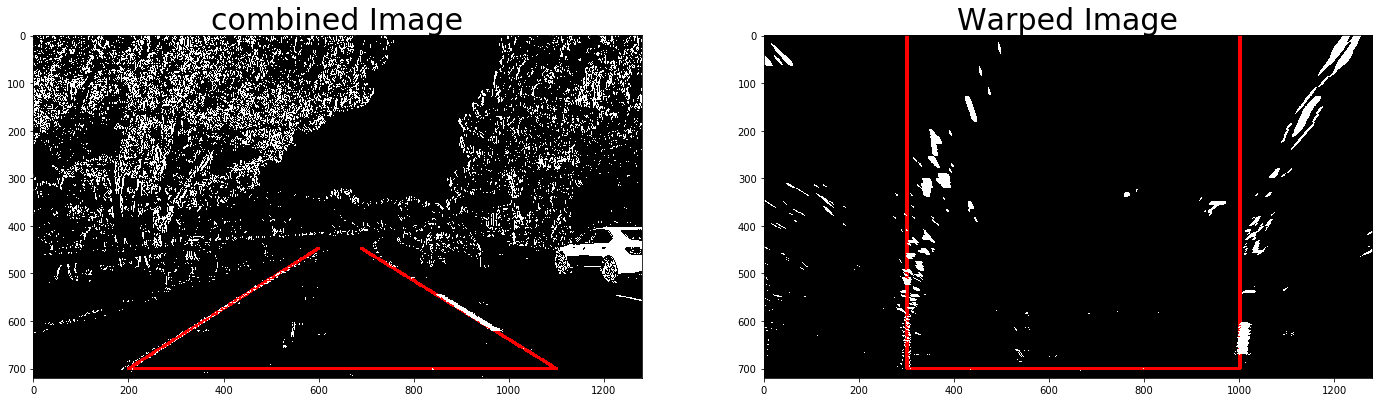

In [87]:
print(combined_binary.shape)
def unwarp(img):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    # 2) Convert to grayscale
    # 3) Find the chessboard corners
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #delete the next two lines
    src = np.float32([[689,447],[1100,700],[200,700],[600,447]])
    dst = np.float32([[1000,0],[1000,700],[300,700],[300,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    return M,warped,src,dst

M,binary_warped,src,dst = unwarp(combined_binary)

src = src.astype(int)
dst = dst.astype(int)
fig = plt.figure(figsize=(24, 9))
ax1 = fig.add_subplot(1,2,1)

out_image = np.dstack((combined_binary, combined_binary, combined_binary))*255
image_base = np.zeros_like(out_image)
cv2.line(image_base,tuple(src[0,:].tolist()),tuple(src[1,:].tolist()),(255,0,0),5)
cv2.line(image_base,tuple(src[1,:].tolist()),tuple(src[2,:].tolist()),(255,0,0),5)
cv2.line(image_base,tuple(src[2,:].tolist()),tuple(src[3,:].tolist()),(255,0,0),5)

ax1.imshow(cv2.addWeighted(image_base, 1, out_image, 5, 0))
ax1.set_title('combined Image', fontsize=30)

image_base = np.zeros_like(out_image)
out_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
cv2.line(image_base,tuple(dst[0,:].tolist()),tuple(dst[1,:].tolist()),(255,0,0),5)
cv2.line(image_base,tuple(dst[1,:].tolist()),tuple(dst[2,:].tolist()),(255,0,0),5)
cv2.line(image_base,tuple(dst[2,:].tolist()),tuple(dst[3,:].tolist()),(255,0,0),5)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.addWeighted(image_base, 1, out_image, 5, 0))
ax2.set_title('Warped Image', fontsize=30)

## Locate the Lane Lines and Fit a Polynomial

(720, 1280)
(1280,)


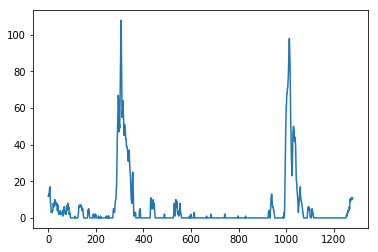

In [88]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
print(binary_warped.shape)
print(histogram.shape)
plt.plot(histogram)

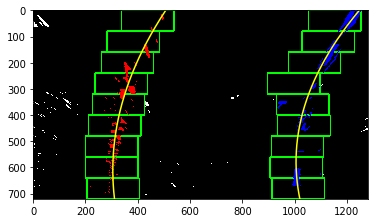

In [89]:
def draw_line(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()#array([  0,   0,   0, ..., 702, 702, 704]), 
                                    #array([248, 249, 250, ..., 522, 894, 763])
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ##plot
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
draw_line(binary_warped)

## Test on all images

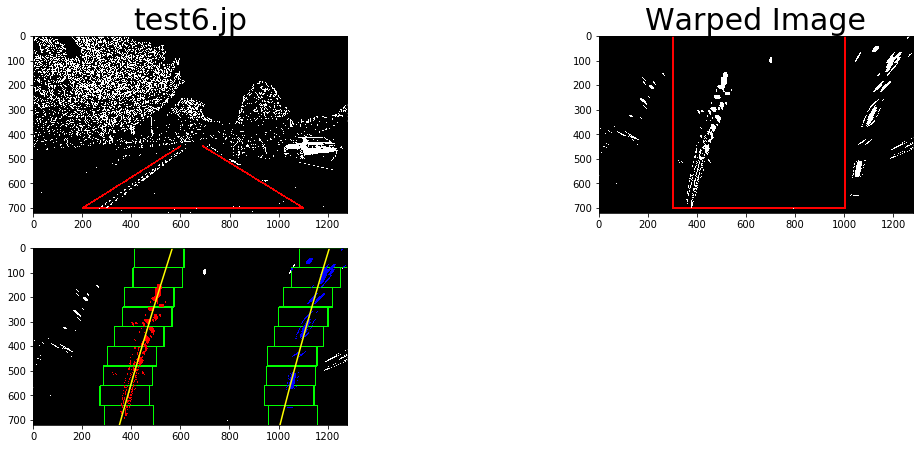

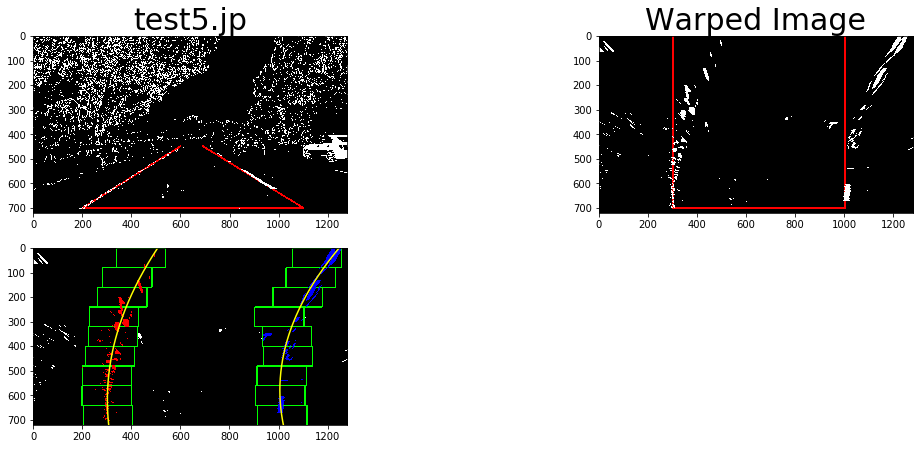

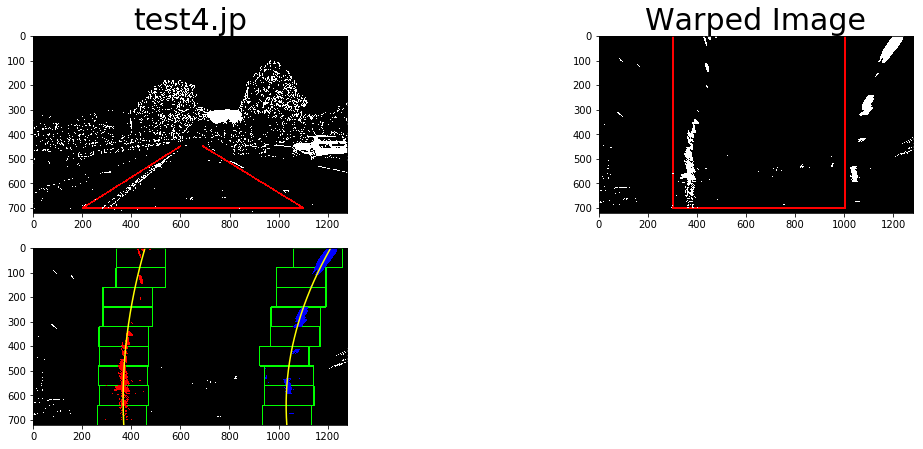

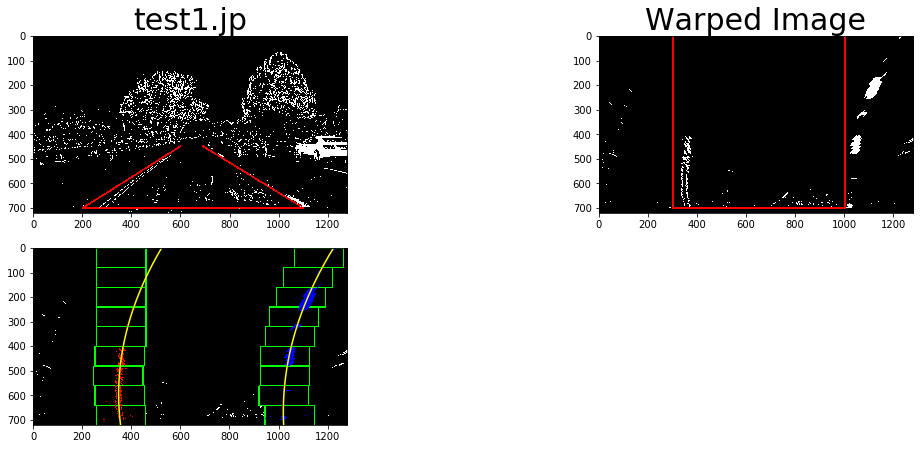

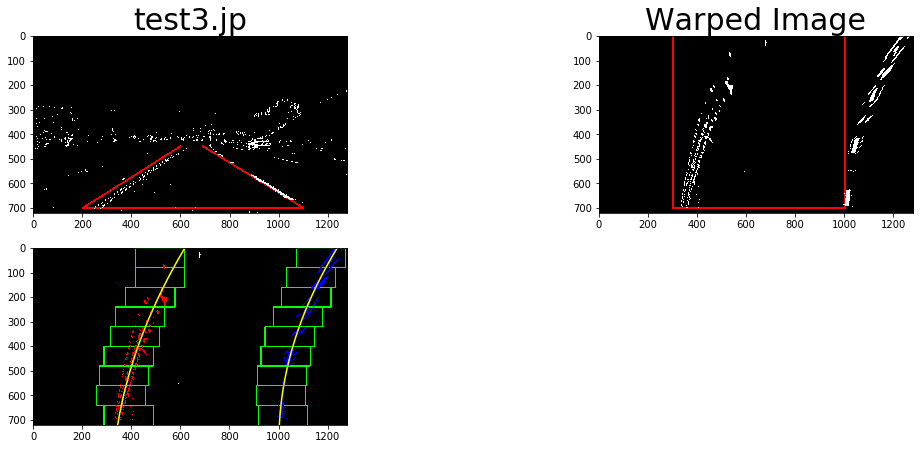

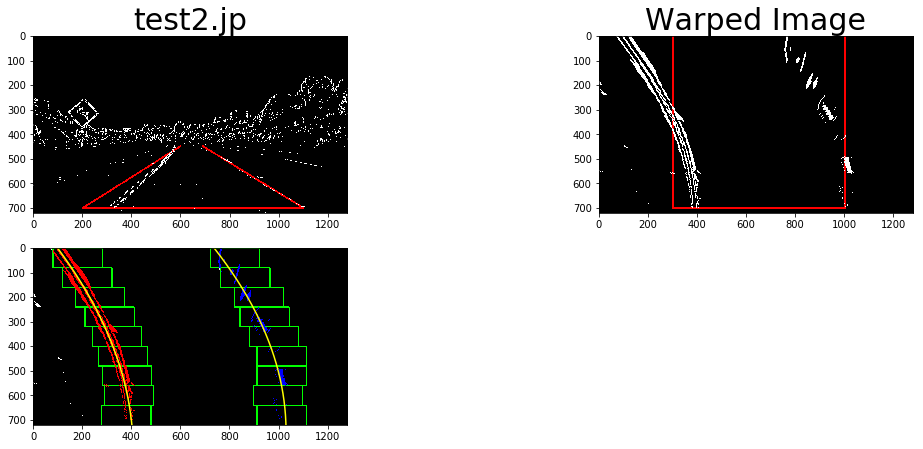

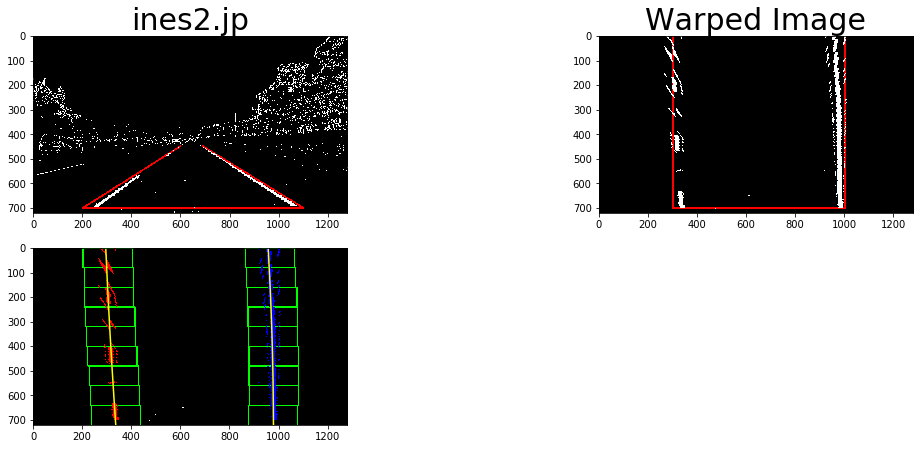

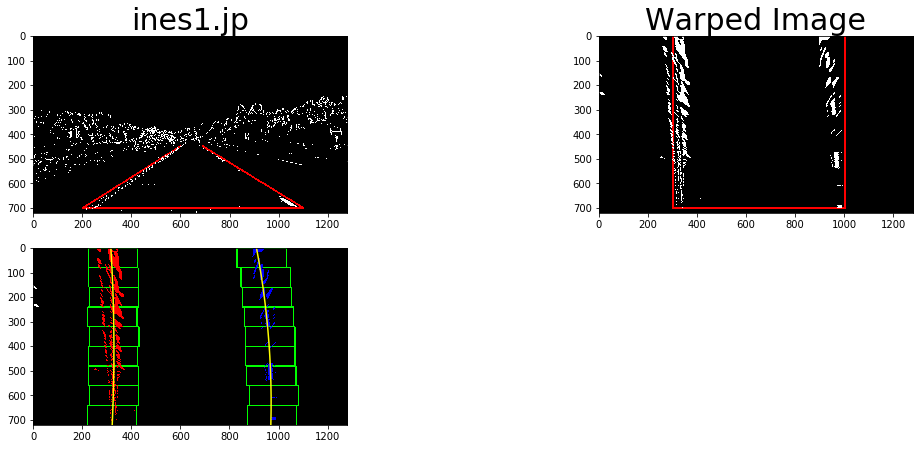

In [90]:
images = glob.glob('../test_images/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)

    undist = undistort_image(img, mtx, dist)

    hls_binary = hls_select(undist, threshmag=(170, 230),threshdir=(0,1.0))
    sobelmagdir_binary = sobelmagdir_select(undist,threshmag=(25,90),threshdir=(0,1.0))
    gray_binary = gray_thresh(undist,thresh=(210,255))
    combined_binary = np.zeros_like(sobelmagdir_binary)
    combined_binary[(hls_binary==1)|(sobelmagdir_binary==1)|(gray_binary==1)]=1

    M,binary_warped,src,dst = unwarp(combined_binary)

    src = src.astype(int)
    dst = dst.astype(int)
    fig = plt.figure(figsize=(48, 18))
    ax1 = fig.add_subplot(2,2,1)

    out_image = np.dstack((combined_binary, combined_binary, combined_binary))*255
    image_base = np.zeros_like(out_image)
    cv2.line(image_base,tuple(src[0,:].tolist()),tuple(src[1,:].tolist()),(255,0,0),5)
    cv2.line(image_base,tuple(src[1,:].tolist()),tuple(src[2,:].tolist()),(255,0,0),5)
    cv2.line(image_base,tuple(src[2,:].tolist()),tuple(src[3,:].tolist()),(255,0,0),5)

    ax1.imshow(cv2.addWeighted(image_base, 1, out_image, 5, 0))
    ax1.set_title(fname[-9:-1], fontsize=30)
    
    ax2 = fig.add_subplot(2,2,2)
    out_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
    image_base = np.zeros_like(out_image)
    cv2.line(image_base,tuple(dst[0,:].tolist()),tuple(dst[1,:].tolist()),(255,0,0),5)
    cv2.line(image_base,tuple(dst[1,:].tolist()),tuple(dst[2,:].tolist()),(255,0,0),5)
    cv2.line(image_base,tuple(dst[2,:].tolist()),tuple(dst[3,:].tolist()),(255,0,0),5)
    
    ax2.imshow(cv2.addWeighted(image_base, 1, out_image, 5, 0))
    ax2.set_title('Warped Image', fontsize=30)
    ax3 = fig.add_subplot(2,2,3)
    draw_line(binary_warped)
    plt.subplots_adjust(left=0., right=0.3, top=0.3, bottom=0.)